tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


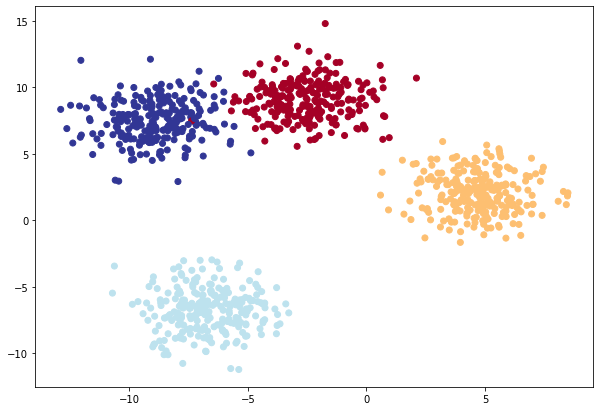

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED,
)
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

from torch import nn


class BlobModel(nn.Module):
    def __init__(
        self, input_features: int, output_features: int, hidden_units: int = 8
    ):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x) -> torch.nn.Sequential:
        return self.linear_layer_stack(x)

In [3]:
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)


In [5]:
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.0741, -0.7000, -1.0017,  0.2487],
        [ 1.2510,  0.5331, -0.5960,  0.4287],
        [-0.9802,  0.7357,  0.6372, -0.5168],
        [-0.4732,  0.5458,  0.2436, -0.2677],
        [ 0.9727,  0.5558, -0.4443,  0.3114]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [6]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 


(torch.Size([4]), 4)

In [7]:
y_logits = model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2492, -0.6120, -1.0166,  0.2982],
        [ 1.1350,  1.1735, -0.0355,  0.2298],
        [-0.9212,  0.4708,  0.4000, -0.4301],
        [-0.1517, -0.5850, -0.8024,  0.1305],
        [ 1.2262,  0.2183, -0.8322,  0.4936]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3630, 0.1534, 0.1024, 0.3812],
        [0.3631, 0.3774, 0.1126, 0.1469],
        [0.0961, 0.3866, 0.3602, 0.1571],
        [0.2860, 0.1855, 0.1492, 0.3793],
        [0.5068, 0.1850, 0.0647, 0.2436]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [8]:
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [9]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))


tensor([0.3630, 0.1534, 0.1024, 0.3812], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [10]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [11]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)  
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.41958, Acc: 27.50% | Test Loss: 0.63519, Test Acc: 83.00%
Epoch: 10 | Loss: 0.16213, Acc: 99.00% | Test Loss: 0.14574, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08786, Acc: 99.00% | Test Loss: 0.07903, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06345, Acc: 99.12% | Test Loss: 0.05541, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05187, Acc: 99.12% | Test Loss: 0.04382, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04525, Acc: 99.12% | Test Loss: 0.03705, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04101, Acc: 99.12% | Test Loss: 0.03265, Test Acc: 99.50%


Epoch: 70 | Loss: 0.03809, Acc: 99.12% | Test Loss: 0.02956, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03597, Acc: 99.12% | Test Loss: 0.02728, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03438, Acc: 99.12% | Test Loss: 0.02553, Test Acc: 99.50%


In [12]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  5.9028,  11.3019, -13.3232,  -7.6070],
        [  4.0568, -11.0338,   2.2991,   9.7934],
        [ -9.7877, -15.1402,  18.1909,   9.8999],
        [  2.3395,   7.8351,  -7.7393,  -5.6565],
        [  9.8659,   5.1832, -13.3518,  -1.8170],
        [  4.4388, -13.8147,   3.6542,  12.0999],
        [ -9.9022, -12.0708,  16.3990,   7.4244],
        [  8.0869,   0.8478,  -8.9498,   1.2352],
        [-10.4301, -20.4241,  22.0849,  13.9692],
        [  8.5748,   2.3986, -10.3813,   0.1094]], device='cuda:0')

In [13]:
y_pred_probs = torch.softmax(y_logits, dim=1)

y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


In [14]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    )
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


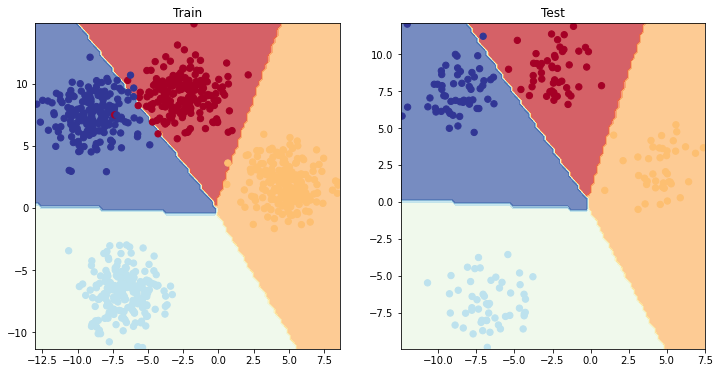

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)